# CS 363D Final Project: Predicting Adoption in Austin Animal Center

## Mrityunjay Mishra, Rohit Neppalli, Ziyi Zhao, Justin Leong 

### Project Description

Many different types of animals (from dogs to livestock) are taken in by the Austin Animal Center each year for various reasons. Some may be adopted, some may be transferred, and some may even go through Euthanasia. The goal of this project is to predict if an animal, that is taken in by the Austin Animal Center, will be adopted or not. This can have good applications for Austin Animal Center - they could use our findings to predict the probability of adoption for an animal that is taken in and can care for it accordingly. Or perhaps someone else can use our findings to find animals who have a low probability of adoption to care for them accordingly. In the end, we hope that our findings provide insight into the adoption patterns of Austin and, consequently, helps different organizations take care of these animal appropriately.

In [32]:
# importing headers
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Enable inline mode for matplotlib so that IPython displays graphs.
%matplotlib inline

### Dataset

To develop our classifier(s), we use the animal intake and outcome data from the open data portal of the city of Austin. To find our more about the animal intake data, [click here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm). To find out more about the outcome data, [click here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In [33]:
# Intakes data
intakes_df = pd.read_csv('Austin_Animal_Center_Intakes.csv')
intakes_df.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,*Brock,01/03/2019 04:19:00 PM,January 2019,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Belle,07/05/2015 12:59:00 PM,July 2015,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Runster,04/14/2016 06:43:00 PM,April 2016,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,NaN,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A682524,Rio,06/29/2014 10:38:00 AM,June 2014,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray


In [34]:
# Outcomes data
outcomes_df = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
outcomes_df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


### Data Cleaning

We can immedietly see that we must combine both `intakes_df` and `outcomes_df` on `Animal ID`. We will first explore and clean both `intakes_df` and `outcomes_df` and combine them in the end.

`Name`, `DateTime`, `MonthYear`, and `Found Location` can immedietly be dropped from `intakes_df` because these features will not have be be relevant to determining if an animal will be adopted or not. The name of the pet animal could be changed after adoption; `DateTime` and `MonthYear` are related to `Age upon Intake` and thus irrelevant (because age is more important than the exact date etc.); and `Found Location` is also irrelevant in adoption matters. 

We may think that `Intake Type` can also be dropped. However, it actually has some useful values that may determine adoption or not. 

In [35]:
intakes_df['Intake Type'].unique()

array(['Stray', 'Owner Surrender', 'Public Assist', 'Wildlife',
       'Euthanasia Request', 'Abandoned'], dtype=object)

Clearly, if an animal is taken into Austin Animal Center on a Euthanasia Request, then its chances for being adopted become drastically low. Other reasons for intake can also play a part in adoption considerations. Therefore, then final columns that are dropped from `intakes_df` are `Name`, `DateTime`, `MonthYear`, `Found Location`.

In [36]:
intakes_df = intakes_df.drop(columns=['Name', 'DateTime', 'MonthYear', 'Found Location'])
intakes_df.head()

,Animal ID,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A682524,Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray


Similarly, `Name`, `DateTime`, `Date of Birth`, and `Outcome Subtype` can immedietly be dropped from `outcomes_df` because there features will not be relevant to classification. Once again, `Name` is clearly irrelevant; the `DateTime` of the outcome makes no difference as to what the outcome is; the `Date of Birth` of the animal is related to its `Age upon Outcome` and thus is not important; and we are not interested in `Outcome Subtype` at the moment. We decided to keep `MonthYear` because it is possible that animals (or some types of animals) are adopted more at certain times of the year (e.x. Christmas) than others. `outcomes_ds` after removing these features is as follows.

In [37]:
outcomes_df = outcomes_df.drop(columns=['Name', 'DateTime', 'Date of Birth', 'Outcome Subtype'])
outcomes_df.head()

,Animal ID,MonthYear,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,May 2019,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Jul 2018,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,Aug 2020,Euthanasia,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Feb 2016,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,Mar 2014,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


As can be seen below, there are some values are missing from some rows in both `intakes_df` and `outcomes_df`. However, this is not a significant number of rows, so we just drop these rows. 

In [38]:
print('Total number of rows in intakes_df: {:d}\n'.format(intakes_df.shape[0]))
print('Number of non-NaN rows (or rows without missing values in general) in intakes_df')
print(intakes_df.count()) 

print('\nTotal number of rows in intakes_df: {:d}\n'.format(outcomes_df.shape[0]))
print('Number of non-NaN rows (or rows without missing values in general) in outcomes_df')
print(outcomes_df.count()) 

Total number of rows in intakes_df: 138350

Number of non-NaN rows (or rows without missing values in general) in intakes_df
Animal ID           138350
Intake Type         138350
Intake Condition    138350
Animal Type         138350
Sex upon Intake     138349
Age upon Intake     138350
Breed               138350
Color               138350
dtype: int64

Total number of rows in intakes_df: 138565

Number of non-NaN rows (or rows without missing values in general) in outcomes_df
Animal ID           138565
MonthYear           138565
Outcome Type        138542
Animal Type         138565
Sex upon Outcome    138564
Age upon Outcome    138559
Breed               138565
Color               138565
dtype: int64


In [39]:
intakes_df.dropna(inplace=True)
outcomes_df.dropna(inplace=True)

We also notice that there are some erroneous values for `Age upon Intake` and `Age upon Outcome` in the `intakes_df` and `outcomes_df`. Thus, we drop these rows (we do not try to rectify such values so as to not skew the data or introduce any other type of bias).

In [ ]:
print('Unique values of Age upon Intake')
print(intakes_df['Age upon Intake'].unique())
print()
print('Unique values of Age upon Outcome')
print(outcomes_df['Age upon Outcome'].unique())

In [ ]:
# Dropping erroneous values in intakes_df
indices = (intakes_df['Age upon Intake'] == '-1 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)
indices = (intakes_df['Age upon Intake'] == '-2 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)
indices = (intakes_df['Age upon Intake'] == '-3 years')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)

# Dropping erroneous values in outcomes_df
indices = (outcomes_df['Age upon Outcome'] == '0 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)
indices = (outcomes_df['Age upon Outcome'] == '-1 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)
indices = (outcomes_df['Age upon Outcome'] == '-2 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)
indices = (outcomes_df['Age upon Outcome'] == '-3 years')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)

print('Unique values of Age upon Intake')
print(intakes_df['Age upon Intake'].unique())
print()
print('Unique values of Age upon Outcome')
print(outcomes_df['Age upon Outcome'].unique())

The same can be noticed for `Sex upon intake` and `Sex upon Outcome` for both `intakes_df` and `outcomes_df`. Both have values of `Unknown` which, while it may not be fully erroneous, is not very useful. Hence, we drop all rows with these values as well. Note that this will not impact us in the long run since we have quite a large amount of data to work with. 

In [ ]:
print('Unique values of Sex upon Intake in intakes_df')
print(intakes_df['Sex upon Intake'].unique())
print()
print('Unique values of Sex upon Outcome in outcomes_df')
print(outcomes_df['Sex upon Outcome'].unique())

In [ ]:
# Dropping erroneous values in intakes_df
indices = (intakes_df['Sex upon Intake'] == 'Unknown')
indices = indices.index[indices == True].tolist()
intakes_df.drop(indices, inplace=True)

# Dropping erroneous values in outcomes_df
indices = (outcomes_df['Sex upon Outcome'] == 'Unknown')
indices = indices.index[indices == True].tolist()
outcomes_df.drop(indices, inplace=True)

print('Unique values of Sex upon Intake in intakes_df')
print(intakes_df['Sex upon Intake'].unique())
print()
print('Unique values of Sex upon Outcome in outcomes_df')
print(outcomes_df['Sex upon Outcome'].unique())

In [40]:
# Make a copy of the cleaned, original dataset for future use
intakes_original = intakes_df.copy()
outcomes_original = outcomes_df.copy()

### Data Exploration and Feature Engineering

We can see that most of the features are categorical data. Specifically, `Intake Type`, `Intake Condition`, `Animal Type`, `Sex upon Intake`, `Breed`, and `Color` are categorical features in `intakes_df`. Similarly, `Outcome Type`, `Animal Type`, `Sex upon Outcome`, `Breed`, and `Color` are all categorial features in `outcomes_df`. We change these feature values from string to labels using `pd.factorize` for ease of use with our classifiers later.

In [41]:
# Assigning labels for intakes_df
categorical_features = ['Intake Type', 'Intake Condition', 'Animal Type', 'Sex upon Intake', 'Breed', 'Color']
intakes_df[categorical_features] = intakes_df[categorical_features].apply(lambda x: pd.factorize(x)[0])

# Assigning labels for outcomes_df
categorical_features = ['Outcome Type', 'Animal Type', 'Sex upon Outcome', 'Breed', 'Color']
outcomes_df[categorical_features] = outcomes_df[categorical_features].apply(lambda x: pd.factorize(x)[0])

We can also see that `Age upon Intake` and `Age upon Outcome` features in `intakes_df` and `outcomes_df` is currently a string. We cast this to a number for better use with our classifiers. 

In [42]:
def standardize_age(age):
  if 'month' in age:
    return 0
  if 'year' in age:
    return int(age.split(' ')[0])
  if 'day' in age:
    return 0
  return 0

intakes_df['Intake Age (Years)'] = intakes_df['Age upon Intake'].apply(lambda x: standardize_age(x))
intakes_df = intakes_df.drop(columns=['Age upon Intake'])

outcomes_df['Outcome Age (Years)'] = outcomes_df['Age upon Outcome'].apply(lambda x: standardize_age(x))
outcomes_df['Outcome Month'] = outcomes_df['MonthYear'].apply(lambda x: x.split(' ')[0])
outcomes_df['Outcome Month'] = outcomes_df['Outcome Month'].map(lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'].index(x) + 1)
outcomes_df['Outcome Year'] = outcomes_df['MonthYear'].apply(lambda x: x.split(' ')[1])
outcomes_df = outcomes_df.drop(columns=['Age upon Outcome', 'MonthYear'])

A number of the animals come in and go out of the animal center multiple times, and we can see that when comparing the number of unique animal id's to the number of total records for both datasets. Since we have so much data, for simplicity sake, we will consider only the animals that have completely unique records in the dataframes

In [43]:
print(len(intakes_df['Animal ID'].unique()))
print(len(intakes_df['Animal ID']))
print(len(outcomes_df['Animal ID'].unique()))
print(len(outcomes_df['Animal ID']))

123675
138349
123863
138535


In [44]:
intakes_df = intakes_df.drop_duplicates(subset=['Animal ID'])
outcomes_df = outcomes_df.drop_duplicates(subset=['Animal ID'])

Now that appropriate pre-processing has been done on both `intakes_df` and `outcomes_df`, we can combine both `intakes_df` and `outcomes_df` on `Animal ID` to get our final dataset. We will drop `Animal ID` because after this point it will not be useful to us for the task of classfication.

In [47]:
# Combine together into singular dataframe
data = intakes_df.merge(outcomes_df[['Animal ID', 'Outcome Type', 'Sex upon Outcome', 'Outcome Age (Years)', 'Outcome Month', 'Outcome Year']], on='Animal ID')
data = data.drop('Animal ID', axis=1)
data.head()

,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Intake Age (Years),Outcome Type,Sex upon Outcome,Outcome Age (Years),Outcome Month,Outcome Year
0,0,0,0,0,0,0,2,3,0,2,1,2019
1,0,0,0,1,1,1,8,4,3,8,7,2015
2,0,0,0,2,2,2,0,4,0,1,4,2016
3,0,1,1,3,3,3,0,3,4,0,10,2013
4,0,0,0,0,4,4,4,4,0,4,7,2014


Now, let's plot a histogram of each feature to check the distribution of its values

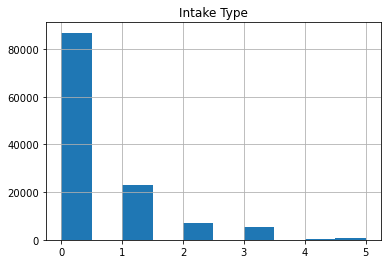

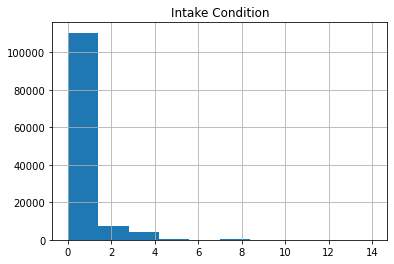

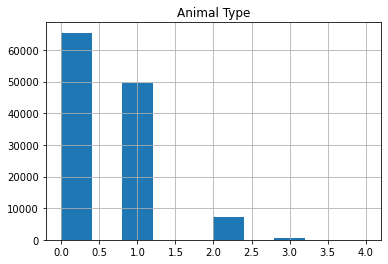

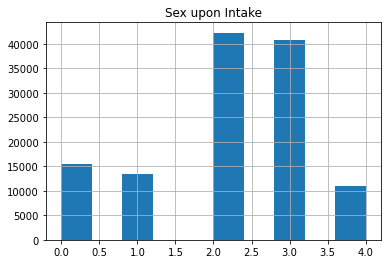

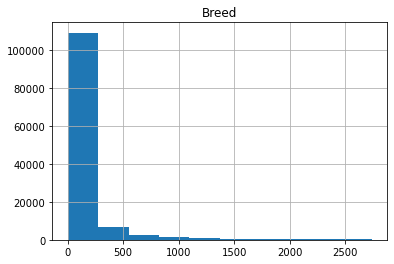

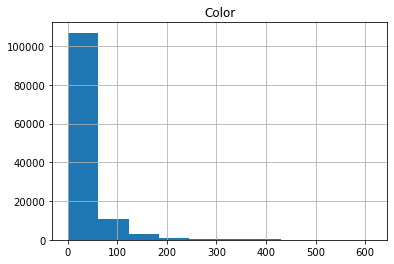

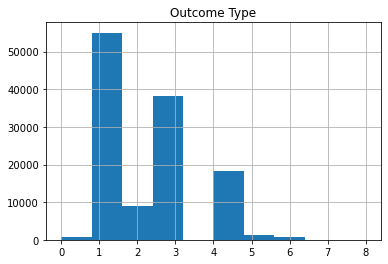

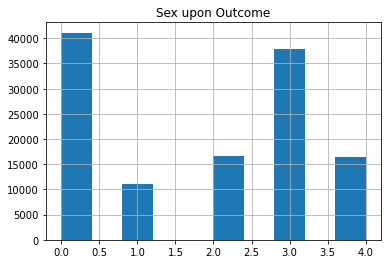

In [50]:
# Plot a histogram of each feature value for all features
# that are categorical features. Note that the x-axis of 
# these histograms is a number, which represents a specific
# label for that feature.
for column in data.columns:
    check = (column == 'Intake Age (Years)' or column == 'Outcome Age (Years)' \
                        or column == 'Outcome Month' or column == 'Outcome Year')
    if check: continue # skip these columns since they are continuous features
    
    data.hist(column=column)

We can see that the class label distribution is extremely imbalanced, with some in the tens of thousands for count, while others less than 100.

In [51]:
data['Outcome Type'].value_counts()

1    55019
3    38194
4    18292
2     8901
5     1270
0      665
6      624
7       60
8       24
Name: Outcome Type, dtype: int64

Looking at the original data (which lists a bunch of duplicate animals), these low categories correspond to things like Missing and Relocate, which do not really align with our goal anyway; furthermore, these class labels clearly do not have enough data associated with them to be releveant in a classifier. So, we will drop these categories to avoid having to heavily oversample or undersample to balance the dataset

In [52]:
outcomes_original['Outcome Type'].value_counts()

Adoption           63422
Transfer           40094
Return to Owner    22995
Euthanasia          9121
Died                1301
Rto-Adopt            876
Disposal             629
Missing               72
Relocate              25
Name: Outcome Type, dtype: int64

In [ ]:
indices = (data['Outcome Type'] == 7)
indices = indices.index[indices == True].tolist()
data.drop(indices, inplace=True)

indices = (data['Outcome Type'] == 6)
indices = indices.index[indices == True].tolist()
data.drop(indices, inplace=True)

indices = (data['Outcome Type'] == 8)
indices = indices.index[indices == True].tolist()
data.drop(indices, inplace=True)

# data['Outcome Type'].value_counts()

In [ ]:
data['Outcome Type'].value_counts()

In [53]:
# low_outcomes = data['Outcome Type'].value_counts()[-3:]
# data = data[~data['Outcome Type'].isin(low_outcomes.index)]
# data['Outcome Type'].value_counts()

Now that we have removed the very low and useless categories, we will use SMOTE to oversample minority data to balance the dataset

In [54]:
# smote = SMOTE(random_state=0)
# features, labels = smote.fit_resample(data.drop('Outcome Type', axis=1), data['Outcome Type'])

# feature_data = []
# for i in labels.unique():
#     indices = np.where(labels == i)[0]
#     feature_data.append(features[features.index.isin(list(indices[:2000]))])

# features = pd.concat(feature_data, ignore_index=True)
# labels_list = []
# for i in labels.unique():
#     labels_list.extend([i] * 2000)
# features['Label'] = labels_list

# features = features.sample(frac=1).reset_index(drop=True)

labels = data['Outcome Type']
features = data.drop('Outcome Type', axis=1)
print(labels.value_counts())
print(features)

1    55019
3    38194
4    18292
2     8901
5     1270
0      665
6      624
7       60
8       24
Name: Outcome Type, dtype: int64
        Intake Type  Intake Condition  Animal Type  Sex upon Intake  Breed  \
0                 0                 0            0                0      0   
1                 0                 0            0                1      1   
2                 0                 0            0                2      2   
3                 0                 1            1                3      3   
4                 0                 0            0                0      4   
...             ...               ...          ...              ...    ...   
123044            1                 0            0                2     19   
123045            1                 0            1                1    104   
123046            1                 0            0                1    182   
123047            2                 0            0                1    136   
123048    

### Data Analysis

#### KNN Classiffier

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

std = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier(n_neighbors=7)
p = Pipeline([('scaler', std), ('pca', pca), ('knn', knn)])
nested_score = cross_val_score(p, features, labels, cv=5)


param_grid = {
    'pca__n_components': list(range(5, 12)),
    'knn__n_neighbors': list(range(1, 25))
}

# your code goes here
search = GridSearchCV(p, param_grid, cv=5)
search.fit(features, labels)
print(search.best_params_)
print("Accuracy:", search.best_score_*100)

#### AdaBoost Ensemble Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

X = data.drop('Outcome Type', axis=1)
y = data['Outcome Type']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', GradientBoostingClassifier()]])

    
param_grid = {
    'classifier__n_estimators': list(range(150,151)),
}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# ada = AdaBoostClassifier(n_estimators=150)
# print(cross_val_score(ada, features, labels, cv=5).mean())

#### AdaBoost with One Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

data_intakes = intakes_original.copy()
data_outcomes = outcomes_original.copy()

def standardize_age(age):
  if 'month' in age:
    return 0
  if 'year' in age:
    return int(age.split(' ')[0])
  if 'day' in age:
    return 0
  return 0

data_intakes['Intake Age (Years)'] = data_intakes['Age upon Intake'].apply(lambda x: standardize_age(x))
data_intakes = data_intakes.drop(columns=['Age upon Intake'])

data_outcomes['Outcome Age (Years)'] = data_outcomes['Age upon Outcome'].apply(lambda x: standardize_age(x))
data_outcomes['Outcome Month'] = data_outcomes['MonthYear'].apply(lambda x: x.split(' ')[0])
data_outcomes['Outcome Month'] = data_outcomes['Outcome Month'].map(lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'].index(x) + 1)
data_outcomes['Outcome Year'] = data_outcomes['MonthYear'].apply(lambda x: x.split(' ')[1])
data_outcomes = data_outcomes.drop(columns=['Age upon Outcome', 'MonthYear'])

data_intakes = data_intakes.drop_duplicates(subset=['Animal ID'])
data_outcomes = data_outcomes.drop_duplicates(subset=['Animal ID'])

# Combine together into singular dataframe
data2 = data_intakes.merge(data_outcomes[['Animal ID', 'Outcome Type', 'Sex upon Outcome', 'Outcome Age (Years)', 'Outcome Month', 'Outcome Year']], on='Animal ID')
data2 = data2.drop('Animal ID', axis=1)
data2.info()

continuous_vars = data2.select_dtypes(["int64"])
categorical_vars = data2.select_dtypes(["object"])
categorical_vars_cols = categorical_vars.columns

one_hot_encoder = OneHotEncoder(sparse=False)
categorical_vars = one_hot_encoder.fit_transform(categorical_vars)
categorical_vars_cols = one_hot_encoder.get_feature_names(categorical_vars_cols)

data3 = pd.DataFrame(data=categorical_vars, columns=categorical_vars_cols)
data3 = pd.concat([data3, continuous_vars], axis=1)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# X = data.drop('Outcome Type', axis=1)
# y = data['Outcome Type']

drops = ['Outcome Type_Transfer', 'Outcome Type_Return to Owner', 'Outcome Type_Adoption', 
         'Outcome Type_Euthanasia', 'Outcome Type_Died', 'Outcome Type_Rto-Adopt', 
         'Outcome Type_Missing', 'Outcome Type_Disposal', 'Outcome Type_Relocate']
holder = data3[data3['Intake Type_Stray'] == 1]
X = holder.drop(drops, axis=1)
y = holder['Outcome Type_Adoption']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', AdaBoostClassifier()]])

    
param_grid = {
    'classifier__n_estimators': list(range(150,151)),
}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# ada = AdaBoostClassifier(n_estimators=150)
# print(cross_val_score(ada, features, labels, cv=5).mean())

### SVM

In [55]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import cross_val_predict

# scaler = StandardScaler()
# pca = PCA()
# svc = SVC()

# # data_copy = data.copy()
# # data_copy.sample(frac=1).reset_index(drop=True)
# # features, labels = data_copy.drop('Outcome Type', axis=1)[:18000], data_copy['Outcome Type'][:18000]

# # pipeline = Pipeline(steps=[('scaling', scaler), ('svc', svc)])
# # param_grid = {
# #     # 'pca__n_components': [5],
# #     'svc__kernel': ['linear']
# # }
# # grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# # predictions = cross_val_predict(grid_search, features, labels, cv=5)

# # print(accuracy_score(labels, predictions))
# # print(classification_report(labels, predictions))

# # print(accuracy_score(labels, predictions))
# # print(classification_report(labels, predictions))
# p = Pipeline([('scaler', scaler), ('pca', pca), ('svc', svc)])
# param_grid = {
#     'pca__n_components': [5],
#     'svc__kernel': ['linear', 'rbf', 'poly']
# }
# search = GridSearchCV(p, param_grid, cv=5)
# search.fit(features, labels)
# preds = cross_val_predict(search, features, labels, cv=5)
# print(classification_report(labels, preds))

## Decision Trees Nested Cross Validation

In [56]:
# Try out some classification approaches, with outcome type as the label
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy')
grid_params = {
    'max_depth': [5, 8, 13], 
    'min_samples_leaf': [5, 10, 15, 20], 
    'max_features': list(range(1, 12))
}
grid_search = GridSearchCV(decision_tree, grid_params, cv=5, scoring='accuracy')
grid_search.fit(features, labels)

print('Best values: ', grid_search.best_params_)
print('Accuracy:', grid_search.best_score_*100)

Best values:  {'max_depth': 13, 'max_features': 9, 'min_samples_leaf': 20}
Accuracy: 73.87708084386988


## k-Nearest Neighbor (KNN)

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

std = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier(n_neighbors=7)
p = Pipeline([('scaler', std), ('pca', pca), ('knn', knn)])
nested_score = cross_val_score(p, features, labels, cv=5)


param_grid = {
    'pca__n_components': list(range(5, 12)),
    'knn__n_neighbors': list(range(1, 25))
}

# your code goes here
search = GridSearchCV(p, param_grid, cv=5)
search.fit(features, labels)
print(search.best_params_)
print("Accuracy:", search.best_score_*100)

{'knn__n_neighbors': 22, 'pca__n_components': 11}
Accuracy: 72.15337318984646


## Naive Bayes (NB) & Evaluation Metrics

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
clf = GaussianNB()
nested_score = cross_val_score(clf, features, labels, cv=10)

preds = cross_val_predict(clf, features, labels)
# print(preds)
mat = confusion_matrix(labels, preds)
print(mat)
print(classification_report(labels, preds))

[[    6   446     7    36   169     0     0     0     1]
 [  207 39141   708  8599  5819   101    80    20   344]
 [   23   966  1108  1685   989    16  4061     0    53]
 [  125 19547   685 13474  3736   177   222    21   207]
 [   91  8952   209   962  7942    39    16     2    79]
 [    3   393    72   541   109     0   139     2    11]
 [    2    38    99    82    12     3   383     0     5]
 [    0    32     0    24     2     0     2     0     0]
 [    0     3     6     1     0     0     8     0     6]]
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       665
           1       0.56      0.71      0.63     55019
           2       0.38      0.12      0.19      8901
           3       0.53      0.35      0.42     38194
           4       0.42      0.43      0.43     18292
           5       0.00      0.00      0.00      1270
           6       0.08      0.61      0.14       624
           7       0.00      0.00      0.00        60

In [59]:
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import cross_val_predict

# predictions = cross_val_predict(grid_search, data.drop('Outcome Type', axis=1), data['Outcome Type'])
# print(confusion_matrix(data['Outcome Type'], predictions))